In [1]:
import pandas as pd
import numpy as np

### **Load data**

In [2]:
#Reading user file:
u_cols =  ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./data/ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

n_users = users.shape[0]
print('Number of users:', n_users)
users.head() #uncomment this to see some few examples

Number of users: 943


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [3]:
#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

rate_train = pd.read_csv('./data/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
rate_test = pd.read_csv('./data/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')

# rate_train = ratings_base.as_matrix()
# rate_test = ratings_test.as_matrix()

print('Number of traing rates:', rate_train.shape[0])
print('Number of test rates:', rate_test.shape[0])

Number of traing rates: 90570
Number of test rates: 9430


In [4]:
print(rate_train.head())
print(rate_test.head())

   user_id  movie_id  rating  unix_timestamp
0        1         1       5       874965758
1        1         2       3       876893171
2        1         3       4       878542960
3        1         4       3       876893119
4        1         5       3       889751712
   user_id  movie_id  rating  unix_timestamp
0        1        20       4       887431883
1        1        33       4       878542699
2        1        61       4       878542420
3        1       117       3       874965739
4        1       155       2       878542201


### **Establish item profiles**

In [5]:
#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 
        'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
        'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('./data/ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')

n_items = items.shape[0]
print('Number of items:', n_items)
items.head(3)

Number of items: 1682


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


* #### *Mark the genres that the films belongs*

In [6]:
item_counter = items.iloc[:,5:]
item_counter.head()

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


* #### *Erect the TF-IDF matrix for the importance percentage of each word in a film*

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

In [8]:
transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
tfidf = transformer.fit_transform(item_counter).toarray()

In [9]:
print(tfidf.shape)
tfidf

(1682, 19)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.53676706, 0.65097024, ..., 0.53676706, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### **Build the recommender model by using the predicted rating of users**

In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
class ContentBasedWithRating():
    def __init__(self, tfidf:TfidfTransformer) -> None:
        self.d = tfidf.shape[1]
        self.W = np.zeros((self.d, n_users))
        self.b = np.zeros((1, n_users))
        self.Yhat = None
    
    def get_items_rated_by_user(self, rate_matrix, user_id) -> tuple:
        """
        in each line of rate_matrix, we have infor: user_id, item_id, rating (scores), time_stamp
        we care about the first three values
        return (item_ids, scores) rated by user user_id
        """
        y = rate_matrix.iloc[:,0] # all users
        
        ids = np.where(y == user_id)[0] # users = user_id
        item_ids = rate_matrix.iloc[ids, 1] # movie_ids of user_id
        scores = rate_matrix.iloc[ids, 2] # rates of those movie_ids
        return item_ids, scores

    def fit_transform(self, rate_train:iter, n_users:int):
        for n in range(1, n_users+1):    
            ids, scores = self.get_items_rated_by_user(rate_train, n)
            # Predict rating of this user by the linear model + regularization
            clf = Ridge(alpha=0.01, fit_intercept = True)
            Xhat = tfidf[ids-1, :]
            
            clf.fit(Xhat, scores) 
            self.W[:, n-1] = clf.coef_
            self.b[0, n-1] = clf.intercept_
        
        # Predict the whole users' rating for each film    
        self.Yhat = tfidf.dot(self.W) + self.b
            
    def predict(self, user_id:int, rate_test:iter, Yhat) -> tuple:      
        np.set_printoptions(precision=2) # 2 digits after . 
        movie_ids, scores = self.get_items_rated_by_user(rate_test, user_id)
        print('Rated movies ids :', movie_ids.to_list())
        print('True ratings     :', scores.to_list())
        print('Predicted ratings:', Yhat[movie_ids-1, user_id-1])
        # Plotting linear regression of rate_test and predicts
        sns.regplot(x=Yhat[movie_ids-1, user_id-1], y=scores)
        plt.xlabel('Predicted scores')
        plt.ylabel('Actual scores')
        
        return movie_ids.to_list(), Yhat[movie_ids-1, user_id-1]
    
    def MSE(self, rates:iter) -> float:
        for n in range(1, n_users+1):
            ids, scores_truth = self.get_items_rated_by_user(rates, n)
            scores_pred = self.Yhat[ids-1, n-1]
            mse = mean_squared_error(y_pred=scores_pred, y_true=scores_truth)
            
            # e = scores_truth - scores_pred 
            # se += (e*e).sum(axis = 0)
            # cnt += e.size
            
        return mse #math.sqrt(se/cnt)
    
def recommend(items, user_id, Yhat):
    return items['movie id'], Yhat[items['movie id']-1, user_id-1]

In [12]:
recommender = ContentBasedWithRating(tfidf=tfidf)

In [13]:
recommender.fit_transform(rate_train, n_users)

Rated movies ids : [20, 33, 61, 117, 155, 160, 171, 189, 202, 265]
True ratings     : [4, 4, 4, 3, 2, 4, 5, 3, 5, 4]
Predicted ratings: [4.13 3.44 4.13 2.8  3.53 4.13 4.44 4.14 3.83 3.1 ]


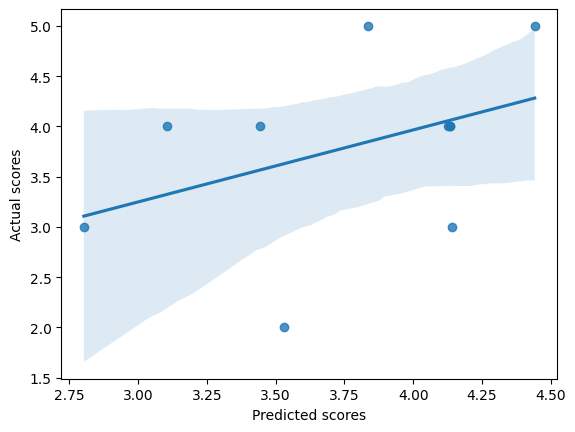

In [14]:
y_pred = recommender.predict(1, rate_test, recommender.Yhat)

In [15]:
print('RMSE for training:', recommender.MSE(rate_train))
print('RMSE for testing', recommender.MSE(rate_test))

RMSE for training: 1.229068050077071
RMSE for testing 0.9125736257924736


### **Dump Yhat to csv file**

In [16]:
np.savetxt('./artificats/recommends.csv', recommender.Yhat, delimiter=',')

In [17]:
Yhat = np.loadtxt('./artificats/recommends.csv', delimiter=',')

In [18]:
Yhat

array([[2.92, 4.  , 1.9 , ..., 5.04, 4.78, 3.17],
       [2.8 , 3.44, 3.3 , ..., 1.1 , 4.76, 3.7 ],
       [3.48, 1.56, 1.27, ..., 7.36, 4.19, 3.81],
       ...,
       [4.13, 4.1 , 3.02, ..., 9.54, 4.64, 3.27],
       [3.57, 3.45, 2.93, ..., 3.68, 3.66, 2.76],
       [4.13, 3.8 , 3.1 , ..., 9.54, 4.42, 3.93]])

In [19]:
def recommend(items, user_id, Yhat):
    return Yhat[items['movie id']-1, user_id-1]

In [20]:
sorted(recommend(items, 1, Yhat).tolist(), reverse=True)

[5.094112001932129,
 5.094112001932129,
 5.094112001932129,
 5.007696626946377,
 4.981646644231931,
 4.8651125218065,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
 4.7963935916933895,
